In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from matplotlib.ticker import FuncFormatter
from matplotlib.ticker import PercentFormatter
import scipy.stats as stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from itertools import combinations
from matplotlib import rcParams

rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Latin Modern Roman"],  # matches Overleaf lmodern
    "mathtext.fontset": "cm",
    "text.latex.preamble": r"\usepackage{lmodern}\usepackage{amsmath}"
})


pd.set_option("display.width", 300)
pd.set_option("display.max_columns", None)
pd.set_option('display.float_format', '{:.6f}'.format)

# Load Data

## Load Embeddings

In [2]:
audience_embeddings = pd.read_parquet("NLP Data/Audience Embeddings/rt_audience_embeddings_aggregated.parquet")
critic_embeddings = pd.read_parquet("NLP Data/Critic Embeddings/rt_critic_embeddings_aggregated.parquet")

print(f"Number of movies in audience embeddings data: {audience_embeddings.shape[0]}",
      f"\nNumber of movies in critic embeddings data: {critic_embeddings.shape[0]}")

Number of movies in audience embeddings data: 9116 
Number of movies in critic embeddings data: 9116


## Load Valence Data

In [3]:
audience_valence = pd.read_json("NLP Data/Audience Sentiment Data/rt_audience_valence_aggregated.json")
critic_valence = pd.read_json("NLP Data/Critic Sentiment Data/rt_critic_valence_aggregated.json")

print(f"Number of movies in audience valence data: {audience_valence.shape[0]}",
      f"\nNumber of movies in critic valence data: {critic_valence.shape[0]}")

Number of movies in audience valence data: 9116 
Number of movies in critic valence data: 9116


## Load 'Movies' Data

In [4]:
movies = pd.read_json("Rotten Tomatoes Reviews/rt_movies_clean.json")

# Merge 'Audience' and 'Critic' Datasets

## Merge 'Audience' and 'Critic' Embeddings

In [5]:
combined_embeddings = pd.merge(left=audience_embeddings.rename(columns={"embeddings": "AudienceEmbeddings"}),
                    right=critic_embeddings.rename(columns={"embeddings": "CriticEmbeddings"}),
                    on="id",
                    how="outer")
combined_embeddings.set_index("id", inplace=True)
combined_embeddings.sort_index(inplace=True)

print(f"Number of rows in combined_embeddings: {combined_embeddings.shape[0]}")
combined_embeddings.head()

Number of rows in combined_embeddings: 9116


,AudienceEmbeddings,CriticEmbeddings
id,,
10000_bc,"[-0.03942528087599016, 0.0032700514138010463, ...","[-0.029380889835797338, 0.013254167158585324, ..."
1000218-accident,"[-0.02399500713051696, -0.0307859453792584, -0...","[-0.00709496159106493, -0.020565725524128147, ..."
10002516-lost_city,"[-0.03502643047207676, 0.010035118767642416, -...","[-0.006343667547931729, -0.007982953772821192,..."
10002635-bridge_of_san_luis_rey,"[-0.01785140314605087, -0.025767731200903653, ...","[-0.014915107875519121, -0.009466946428195419,..."
10003276-criminal,"[-0.052772209397953705, -0.027951262337912338,...","[-0.036120476975689784, -0.0379468278341188, -..."


## Merge 'Audience' and 'Critic' Valence Data

In [6]:
combined_valence = pd.merge(left=audience_valence.rename(columns={"AvgValence": "AvgAudienceValence"}),
                            right=critic_valence.rename(columns={"AvgValence": "AvgCriticValence"}),
                             on="id",
                             how="outer")
combined_valence.set_index("id", inplace=True)
combined_valence.sort_index(inplace=True)

print(f"Number of rows in combined_valence: {combined_valence.shape[0]}")
combined_valence.head()

Number of rows in combined_valence: 9116


,AvgAudienceValence,AvgCriticValence
id,,
10000_bc,-0.208172,-0.410251
1000218-accident,0.534362,0.424794
10002516-lost_city,0.567837,-0.158982
10002635-bridge_of_san_luis_rey,-0.028470,-0.647940
10003276-criminal,0.313468,0.281749


# Calculate Divergence/Similarity Metrics

## Calculate Cosine Similarity

In [7]:
combined_embeddings["CosineSimilarity"] = combined_embeddings.apply(lambda row: cosine_similarity([row["AudienceEmbeddings"]], [row["CriticEmbeddings"]])[0][0], axis=1)
combined_embeddings.head()

,AudienceEmbeddings,CriticEmbeddings,CosineSimilarity
id,,,
10000_bc,"[-0.03942528087599016, 0.0032700514138010463, ...","[-0.029380889835797338, 0.013254167158585324, ...",0.902636
1000218-accident,"[-0.02399500713051696, -0.0307859453792584, -0...","[-0.00709496159106493, -0.020565725524128147, ...",0.901405
10002516-lost_city,"[-0.03502643047207676, 0.010035118767642416, -...","[-0.006343667547931729, -0.007982953772821192,...",0.888783
10002635-bridge_of_san_luis_rey,"[-0.01785140314605087, -0.025767731200903653, ...","[-0.014915107875519121, -0.009466946428195419,...",0.810171
10003276-criminal,"[-0.052772209397953705, -0.027951262337912338,...","[-0.036120476975689784, -0.0379468278341188, -...",0.898567


## Create Column Containing Difference of Average Audience and Critic Sentiment

In [8]:
combined_valence["ValenceDifference"] = (combined_valence["AvgAudienceValence"] - combined_valence["AvgCriticValence"])
combined_valence["AbsValenceDifference"] = combined_valence["ValenceDifference"].abs()

combined_valence.head()

,AvgAudienceValence,AvgCriticValence,ValenceDifference,AbsValenceDifference
id,,,,
10000_bc,-0.208172,-0.410251,0.202079,0.202079
1000218-accident,0.534362,0.424794,0.109568,0.109568
10002516-lost_city,0.567837,-0.158982,0.726819,0.726819
10002635-bridge_of_san_luis_rey,-0.028470,-0.647940,0.619471,0.619471
10003276-criminal,0.313468,0.281749,0.031719,0.031719


# Compartmentalize by Valence and Content Similarity

## Merge Valence and Embeddings data for Grouping

In [9]:
Val_Con_Total = combined_valence.merge(combined_embeddings, on="id", how="inner")[["AbsValenceDifference", "ValenceDifference", "CosineSimilarity"]]

print(f"Total Rows: {Val_Con_Total.shape[0]}")
Val_Con_Total

Total Rows: 9116


,AbsValenceDifference,ValenceDifference,CosineSimilarity
id,,,
10000_bc,0.202079,0.202079,0.902636
1000218-accident,0.109568,0.109568,0.901405
10002516-lost_city,0.726819,0.726819,0.888783
10002635-bridge_of_san_luis_rey,0.619471,0.619471,0.810171
10003276-criminal,0.031719,0.031719,0.898567
...,...,...,...
zoo,0.309993,-0.309993,0.904870
zookeeper,0.524547,0.524547,0.904950
zoolander,0.221285,0.221285,0.906266


## Compartmentalise Data into Groups Based on Valence Difference and Review Content Divergence

In [10]:
cutoff = 0.25

# Similar Valence and Similar Review Content
sameVal_sameCon = Val_Con_Total[(Val_Con_Total["AbsValenceDifference"] <= Val_Con_Total["AbsValenceDifference"].quantile(cutoff)) &
                                (Val_Con_Total["CosineSimilarity"] > Val_Con_Total["CosineSimilarity"].quantile(1-cutoff))]

# Similar Valence but Diverging Review Content
sameVal_diffCon = Val_Con_Total[(Val_Con_Total["AbsValenceDifference"] <= Val_Con_Total["AbsValenceDifference"].quantile(cutoff)) &
                                (Val_Con_Total["CosineSimilarity"] <= Val_Con_Total["CosineSimilarity"].quantile(cutoff))]

# Different Valence but Similar Review Content
diffVal_sameCon = Val_Con_Total[(Val_Con_Total["AbsValenceDifference"] > Val_Con_Total["AbsValenceDifference"].quantile(1-cutoff)) &
                                (Val_Con_Total["CosineSimilarity"] > Val_Con_Total["CosineSimilarity"].quantile(1-cutoff))]

# Different Valence and Diverging Review Content
diffVal_diffCon = Val_Con_Total[(Val_Con_Total["AbsValenceDifference"] > Val_Con_Total["AbsValenceDifference"].quantile(1-cutoff)) &
                                (Val_Con_Total["CosineSimilarity"] <= Val_Con_Total["CosineSimilarity"].quantile(cutoff))]

## Group Sizes

In [11]:
print(f"Number of Movies with Similar Valence, Similar Review Content: {sameVal_sameCon.shape[0]}",
      f"\nNumber of Movies with Similar Valence, Diverging Review Content: {sameVal_diffCon.shape[0]}",
      f"\nNumber of Movies with Different Valence, Similar Review Content: {diffVal_sameCon.shape[0]}",
      f"\nNumber of Movies with Different Valence, Diverging Review Content: {diffVal_diffCon.shape[0]}")

Number of Movies with Similar Valence, Similar Review Content: 830 
Number of Movies with Similar Valence, Diverging Review Content: 390 
Number of Movies with Different Valence, Similar Review Content: 184 
Number of Movies with Different Valence, Diverging Review Content: 939


# Group Characteristics

## Descriptive Statistics

### Similar Valence, Similar Content

In [12]:
sameVal_sameCon = sameVal_sameCon.merge(right=movies, on="id", how="left")

sameVal_sameCon.describe(include="all")

,id,AbsValenceDifference,ValenceDifference,CosineSimilarity,title,audienceScore,tomatoMeter,ageRating,ratingContents,releaseDateTheaters,releaseDateStreaming,runtimeMinutes,genre,originalLanguage,director,releaseYear,boxOffice
count,830,830.000000,830.000000,830.000000,830,830.000000,830.000000,603,830,796,823,829.000000,829,827,830,829.000000,830.000000
unique,830,NaN,NaN,NaN,830,NaN,NaN,4,526,644,590,NaN,235,34,618,NaN,NaN
top,1000626-all_about_eve,NaN,NaN,NaN,All About Eve,NaN,NaN,R,[],2015-10-16T00:00:00.000,2016-03-01T00:00:00.000,NaN,[Drama],English,Woody Allen,NaN,NaN
freq,1,NaN,NaN,NaN,1,NaN,NaN,363,227,4,5,NaN,112,669,7,NaN,NaN
mean,NaN,0.049905,0.004822,0.935246,NaN,72.683133,79.363855,NaN,NaN,NaN,NaN,109.955368,NaN,NaN,NaN,2007.156815,32915571.837349
std,NaN,0.028335,0.057211,0.008884,NaN,17.790147,19.155453,NaN,NaN,NaN,NaN,21.077306,NaN,NaN,NaN,14.066423,62577605.535686
min,NaN,0.000073,-0.099987,0.921829,NaN,11.000000,1.000000,NaN,NaN,NaN,NaN,43.000000,NaN,NaN,NaN,1927.000000,1725.000000
25%,NaN,0.024836,-0.045691,0.928155,NaN,62.000000,72.000000,NaN,NaN,NaN,NaN,95.000000,NaN,NaN,NaN,2004.000000,413925.000000
50%,NaN,0.050485,0.007346,0.934271,NaN,78.000000,86.000000,NaN,NaN,NaN,NaN,106.000000,NaN,NaN,NaN,2011.000000,4200000.000000
75%,NaN,0.074802,0.056219,0.941039,NaN,86.000000,93.000000,NaN,NaN,NaN,NaN,120.000000,NaN,NaN,NaN,2015.000000,38000000.000000


### Similar Valence, Diverging Content

In [13]:
sameVal_diffCon = sameVal_diffCon.merge(right=movies, on="id", how="left")

sameVal_diffCon.describe(include="all")

,id,AbsValenceDifference,ValenceDifference,CosineSimilarity,title,audienceScore,tomatoMeter,ageRating,ratingContents,releaseDateTheaters,releaseDateStreaming,runtimeMinutes,genre,originalLanguage,director,releaseYear,boxOffice
count,390,390.000000,390.000000,390.000000,390,385.000000,390.000000,140,390,326,357,389.000000,389,389,390,385.000000,390.000000
unique,390,NaN,NaN,NaN,390,NaN,NaN,3,123,300,319,NaN,86,29,378,NaN,NaN
top,10003284-the_zodiac,NaN,NaN,NaN,The Zodiac,NaN,NaN,R,[],2022-08-26T00:00:00.000,2007-06-11T00:00:00.000,NaN,[Drama],English,Steve James,NaN,NaN
freq,1,NaN,NaN,NaN,1,NaN,NaN,84,250,3,4,NaN,104,285,3,NaN,NaN
mean,NaN,0.052177,0.004536,0.829007,NaN,66.867532,73.856410,NaN,NaN,NaN,NaN,99.897172,NaN,NaN,NaN,2008.761039,4948098.838462
std,NaN,0.029023,0.059591,0.059322,NaN,19.116436,20.823037,NaN,NaN,NaN,NaN,18.368640,NaN,NaN,NaN,9.633927,15924185.850427
min,NaN,0.000506,-0.100421,0.271387,NaN,14.000000,5.000000,NaN,NaN,NaN,NaN,40.000000,NaN,NaN,NaN,1968.000000,371.000000
25%,NaN,0.026486,-0.048098,0.820212,NaN,54.000000,63.000000,NaN,NaN,NaN,NaN,90.000000,NaN,NaN,NaN,2003.000000,29800.000000
50%,NaN,0.051731,0.008424,0.846932,NaN,70.000000,79.000000,NaN,NaN,NaN,NaN,97.000000,NaN,NaN,NaN,2009.000000,97350.000000
75%,NaN,0.079060,0.061019,0.860943,NaN,83.000000,90.000000,NaN,NaN,NaN,NaN,107.000000,NaN,NaN,NaN,2017.000000,670075.000000


### Different Valences, Similar Content

In [14]:
diffVal_sameCon = diffVal_sameCon.merge(right=movies, on="id", how="left")

diffVal_sameCon.describe(include="all")

,id,AbsValenceDifference,ValenceDifference,CosineSimilarity,title,audienceScore,tomatoMeter,ageRating,ratingContents,releaseDateTheaters,releaseDateStreaming,runtimeMinutes,genre,originalLanguage,director,releaseYear,boxOffice
count,184,184.000000,184.000000,184.000000,184,184.000000,184.000000,151,184,177,182,182.000000,182,182,184,182.000000,184.000000
unique,184,NaN,NaN,NaN,184,NaN,NaN,3,148,166,169,NaN,82,16,172,NaN,NaN
top,10007415-amazing_grace,NaN,NaN,NaN,Amazing Grace,NaN,NaN,R,[],2021-10-08T00:00:00.000,2016-01-26T00:00:00.000,NaN,[Comedy],English,Michael Bay,NaN,NaN
freq,1,NaN,NaN,NaN,1,NaN,NaN,82,33,2,3,NaN,20,160,2,NaN,NaN
mean,NaN,0.492240,0.073702,0.929137,NaN,60.282609,59.527174,NaN,NaN,NaN,NaN,107.401099,NaN,NaN,NaN,2011.401099,43413876.461957
std,NaN,0.089162,0.496097,0.006604,NaN,16.136593,28.423598,NaN,NaN,NaN,NaN,19.097846,NaN,NaN,NaN,7.808382,73807291.282333
min,NaN,0.391235,-0.793378,0.921740,NaN,24.000000,4.000000,NaN,NaN,NaN,NaN,72.000000,NaN,NaN,NaN,1967.000000,369.000000
25%,NaN,0.425825,-0.459694,0.924268,NaN,48.000000,35.750000,NaN,NaN,NaN,NaN,93.000000,NaN,NaN,NaN,2008.000000,745250.000000
50%,NaN,0.466666,0.410108,0.927105,NaN,60.500000,62.500000,NaN,NaN,NaN,NaN,105.000000,NaN,NaN,NaN,2013.000000,15650000.000000
75%,NaN,0.538095,0.472819,0.931908,NaN,73.000000,85.250000,NaN,NaN,NaN,NaN,118.000000,NaN,NaN,NaN,2016.000000,50375000.000000


### Different Valences, Diverging Content

In [15]:
diffVal_diffCon = diffVal_diffCon.merge(right=movies, how="left", on="id")

diffVal_diffCon.describe(include="all")

,id,AbsValenceDifference,ValenceDifference,CosineSimilarity,title,audienceScore,tomatoMeter,ageRating,ratingContents,releaseDateTheaters,releaseDateStreaming,runtimeMinutes,genre,originalLanguage,director,releaseYear,boxOffice
count,939,939.000000,939.000000,939.000000,939,914.000000,938.000000,528,939,849,883,934.000000,935,935,937,924.000000,939.000000
unique,939,NaN,NaN,NaN,939,NaN,NaN,3,448,675,670,NaN,174,31,824,NaN,NaN
top,10002635-bridge_of_san_luis_rey,NaN,NaN,NaN,The Bridge of San Luis Rey,NaN,NaN,R,[],2002-04-05T00:00:00.000,2002-02-05T00:00:00.000,NaN,[Drama],English,Tyler Perry,NaN,NaN
freq,1,NaN,NaN,NaN,1,NaN,NaN,231,411,4,6,NaN,193,760,12,NaN,NaN
mean,NaN,0.648146,0.336659,0.817874,NaN,60.750547,46.101279,NaN,NaN,NaN,NaN,101.194861,NaN,NaN,NaN,2008.589827,11286583.511182
std,NaN,0.199134,0.588842,0.073863,NaN,17.879330,28.307078,NaN,NaN,NaN,NaN,15.698272,NaN,NaN,NaN,9.059186,25214586.841978
min,NaN,0.392202,-1.629598,0.105155,NaN,12.000000,0.000000,NaN,NaN,NaN,NaN,39.000000,NaN,NaN,NaN,1941.000000,825.000000
25%,NaN,0.498696,0.407117,0.806523,NaN,48.000000,21.250000,NaN,NaN,NaN,NaN,91.000000,NaN,NaN,NaN,2002.000000,44550.000000
50%,NaN,0.607060,0.536949,0.841001,NaN,61.000000,42.000000,NaN,NaN,NaN,NaN,99.000000,NaN,NaN,NaN,2007.000000,489300.000000
75%,NaN,0.751195,0.699234,0.858628,NaN,75.000000,68.000000,NaN,NaN,NaN,NaN,109.000000,NaN,NaN,NaN,2017.000000,12400000.000000


## 'Popcorn Meter' Score Distributions

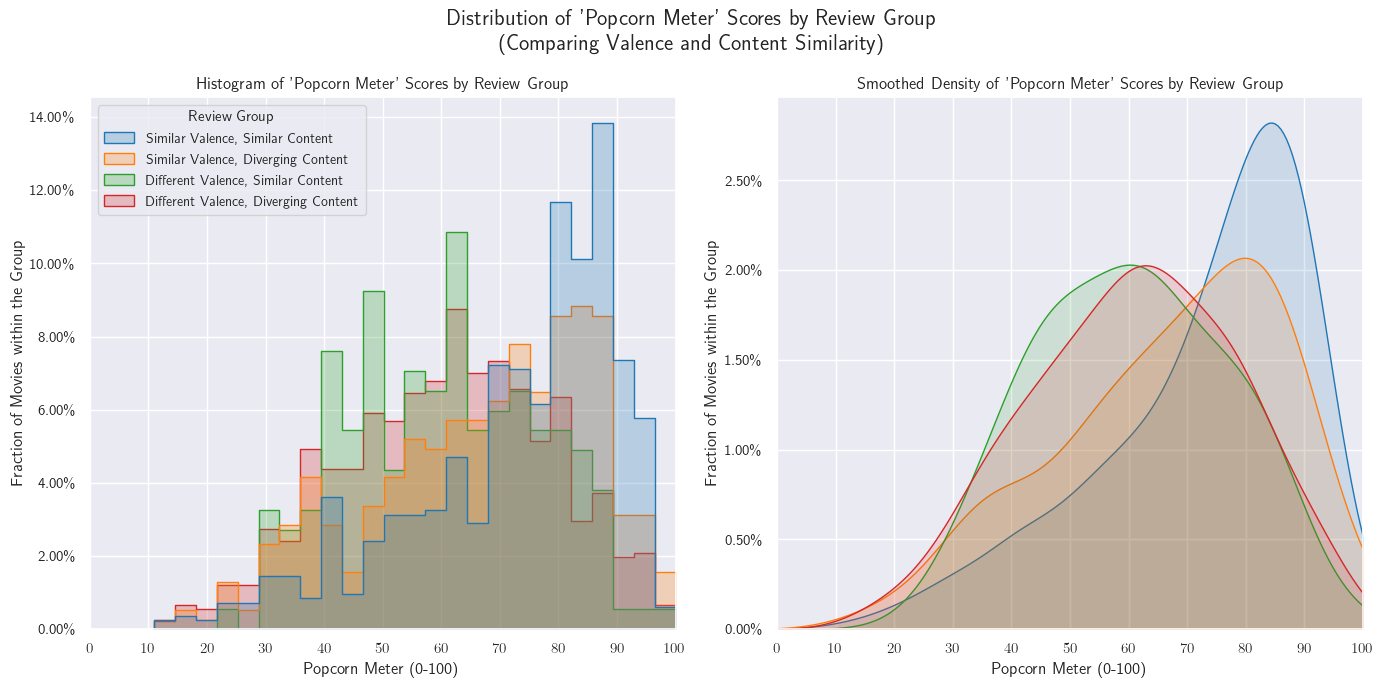

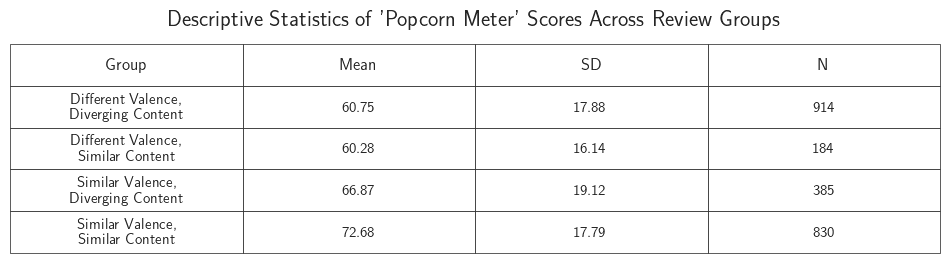

In [16]:
# Combine subsets into a single DataFrame to use "hue" functionality
sameVal_sameCon["group"] = "Similar Valence, Similar Content"
sameVal_diffCon["group"] = "Similar Valence, Diverging Content"
diffVal_sameCon["group"] = "Different Valence, Similar Content"
diffVal_diffCon["group"] = "Different Valence, Diverging Content"

combined = pd.concat([sameVal_sameCon, sameVal_diffCon, diffVal_sameCon, diffVal_diffCon], ignore_index=True)

# Define consistent color mapping
group_order = [
    "Similar Valence, Similar Content",
    "Similar Valence, Diverging Content",
    "Different Valence, Similar Content",
    "Different Valence, Diverging Content"
]

palette = sns.color_palette("tab10", n_colors=4)
group_palette = dict(zip(group_order, palette))


sns.set_theme(style="darkgrid")
fig, axes = plt.subplots(1,2, figsize=(14,7))
plt.suptitle("Distribution of 'Popcorn Meter' Scores by Review Group\n(Comparing Valence and Content Similarity)", fontweight="bold", fontsize=16)

# Histplot
sns.histplot(data=combined, x="audienceScore", hue="group", bins=25, element="step", stat="probability", common_norm=False, palette=group_palette, ax=axes[0], legend=True)
axes[0].set_title("Histogram of 'Popcorn Meter' Scores by Review Group", fontweight="bold")

# Format the automatically created legend
leg = axes[0].get_legend()
leg.set_title("Review Group")
plt.setp(leg.get_title(), fontsize=11, fontweight="bold")
plt.setp(leg.get_texts(), fontsize=10)

# KDE
for group in combined["group"].unique():
    sns.kdeplot(data=combined[combined["group"] == group], x="audienceScore", color=group_palette[group], bw_adjust=1.2, clip=(0, 100), ax=axes[1], fill=True, alpha=0.15)
axes[1].set_title("Smoothed Density of 'Popcorn Meter' Scores by Review Group", fontweight="bold")

# Common styling for Plots
for ax in axes:
    ax.set_xlim(0, 100)
    ax.set_xticks(np.arange(0, 101, 10))
    ax.set_xlabel("Popcorn Meter (0-100)")
    ax.set_ylabel("Fraction of Movies within the Group")
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{100*y:.2f}\%'))

plt.tight_layout()
plt.show()

sns.set_theme(style="white")
plt.figure(figsize=(8,3))
plt.axis("off")
plt.title("Descriptive Statistics of 'Popcorn Meter' Scores Across Review Groups", fontweight="bold", fontsize=16)

# Summary Statistics
summary = combined.groupby("group").agg(Mean = ("audienceScore", "mean"),
                                        SD = ("audienceScore", "std"),
                                        N = ("audienceScore", "count")).reset_index().round({"Mean": 2, "SD": 2})
summary["group"] = summary["group"].replace({"Similar Valence, Similar Content": "Similar Valence,\nSimilar Content",
                                             "Similar Valence, Diverging Content": "Similar Valence,\nDiverging Content",
                                             "Different Valence, Similar Content": "Different Valence,\nSimilar Content",
                                             "Different Valence, Diverging Content": "Different Valence,\nDiverging Content"})
summary.rename(columns={"group": "Group"}, inplace=True)

# Create Table
table = plt.table(cellText = summary.values,
                      colLabels = summary.columns,
                      loc = "center",
                      cellLoc = "center")
table.scale(1.5, 2.5)

table.auto_set_font_size(False)
table.set_fontsize(11)
for key, cell in table.get_celld().items():
    cell.set_linewidth(0.5)
    if key[0] == 0:
        cell.set_fontsize(12)
        cell.set_text_props(weight="bold")




plt.show()


### Test for Normality

In [17]:
# Test  H₀: distribution is normal
#       H₁: distribution is not normal

stat1, p1 = stats.shapiro(sameVal_sameCon.dropna(subset=["audienceScore"])["audienceScore"])
stat2, p2 = stats.shapiro(sameVal_diffCon.dropna(subset=["audienceScore"])["audienceScore"])
stat3, p3 = stats.shapiro(diffVal_sameCon.dropna(subset=["audienceScore"])["audienceScore"])
stat4, p4 = stats.shapiro(diffVal_diffCon.dropna(subset=["audienceScore"])["audienceScore"])

print(f"Shapiro-Wilk test for normality:",
      f"\nSimilar Valence, Similar Content: {p1:.4f}",
      f"\nSimilar Valence, Diverging Content: {p2:.4f}",
      f"\nDifferent Valence, Similar Content: {p3:.4f}",
      f"\nDifferent Valence, Diverging Content: {p4:.4f}")

Shapiro-Wilk test for normality: 
Similar Valence, Similar Content: 0.0000 
Similar Valence, Diverging Content: 0.0000 
Different Valence, Similar Content: 0.0234 
Different Valence, Diverging Content: 0.0000


### Test for Log-Normality

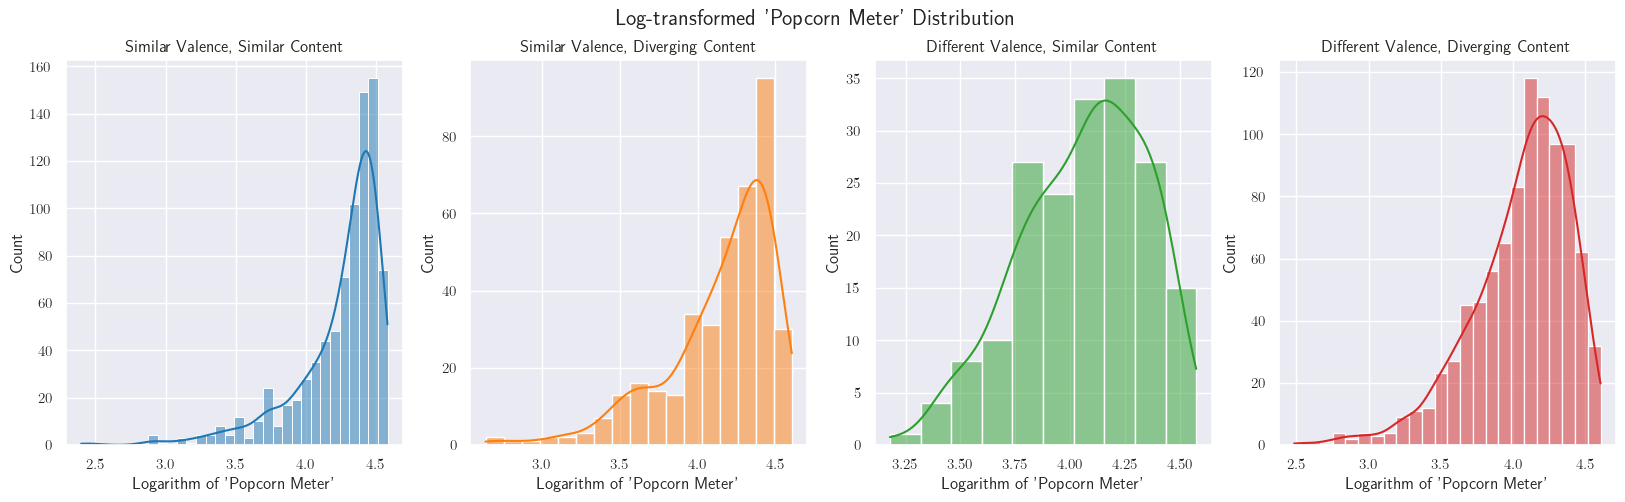

Shapiro-Wilk test for lognormality: 
Similar Valence, Similar Content: 0.0000 
Similar Valence, Diverging Content: 0.0000 
Different Valence, Similar Content: 0.0004 
Different Valence, Diverging Content: 0.0000


In [18]:
# Test  H₀: distribution is log-normal
#       H₁: distribution is not log-normal

sns.set_theme(style="darkgrid")
fig, axes = plt.subplots(1,4, figsize=(20,5))
plt.suptitle("Log-transformed 'Popcorn Meter' Distribution", fontweight="bold", fontsize=16)

log_values1 = np.log(sameVal_sameCon.dropna(subset=["audienceScore"])["audienceScore"])
sns.histplot(log_values1, kde=True, ax=axes[0], color=group_palette["Similar Valence, Similar Content"])
axes[0].set_xlabel("Logarithm of 'Popcorn Meter'")
axes[0].set_title("Similar Valence, Similar Content")

log_values2 = np.log(sameVal_diffCon.dropna(subset=["audienceScore"])["audienceScore"])
sns.histplot(log_values2, kde=True, ax=axes[1], color=group_palette["Similar Valence, Diverging Content"])
axes[1].set_xlabel("Logarithm of 'Popcorn Meter'")
axes[1].set_title("Similar Valence, Diverging Content")

log_values3 = np.log(diffVal_sameCon.dropna(subset=["audienceScore"])["audienceScore"])
sns.histplot(log_values3, kde=True, ax=axes[2], color=group_palette["Different Valence, Similar Content"])
axes[2].set_xlabel("Logarithm of 'Popcorn Meter'")
axes[2].set_title("Different Valence, Similar Content")

log_values4 = np.log(diffVal_diffCon.dropna(subset=["audienceScore"])["audienceScore"])
sns.histplot(log_values4, kde=True, ax=axes[3], color=group_palette["Different Valence, Diverging Content"])
axes[3].set_xlabel("Logarithm of 'Popcorn Meter'")
axes[3].set_title("Different Valence, Diverging Content")

plt.show()

# Test for normality (lognormality implies this should be ~normal)
stat1, p1 = stats.shapiro(log_values1)
stat2, p2 = stats.shapiro(log_values2)
stat3, p3 = stats.shapiro(log_values3)
stat4, p4 = stats.shapiro(log_values4)

print(f"Shapiro-Wilk test for lognormality:",
      f"\nSimilar Valence, Similar Content: {p1:.4f}",
      f"\nSimilar Valence, Diverging Content: {p2:.4f}",
      f"\nDifferent Valence, Similar Content: {p3:.4f}",
      f"\nDifferent Valence, Diverging Content: {p4:.4f}")


### Kruskal-Wallis H-Test (Test if the Distributions differ from each other)

In [19]:
# Test  H₀: distributions are identical
#       H₁: at least one distribution differs

groups = [g["audienceScore"].dropna() for _, g in combined.groupby("group")]
H, p = stats.kruskal(*groups)
print(f"Kruskal–Wallis H = {H:.3f}, p = {p:.4f}")

Kruskal–Wallis H = 231.719, p = 0.0000


### Pairwise Mann-Whitney U-Tests

In [20]:
# Test  H₀: distributions are identical
#       H₁: distribution differ from each other

groups_dict = {name: g["audienceScore"].dropna() for name, g in combined.groupby("group")}

pairs = []
for (g1, g2) in combinations(groups_dict.keys(), 2):
    u, p = stats.mannwhitneyu(groups_dict[g1], groups_dict[g2], alternative='two-sided')
    pairs.append([g1, g2, u, p])

results = pd.DataFrame(pairs, columns=["Group 1", "Group 2", "U-statistic", "p-value"])
results["p (Bonferroni)"] = results["p-value"] * len(results)
results["Significant"] = results["p (Bonferroni)"] < 0.05
print(results)

                                Group 1                             Group 2   U-statistic  p-value  p (Bonferroni)  Significant
0  Different Valence, Diverging Content  Different Valence, Similar Content  86242.500000 0.583050        3.498299        False
1  Different Valence, Diverging Content  Similar Valence, Diverging Content 139489.500000 0.000000        0.000000         True
2  Different Valence, Diverging Content    Similar Valence, Similar Content 228963.500000 0.000000        0.000000         True
3    Different Valence, Similar Content  Similar Valence, Diverging Content  27054.000000 0.000005        0.000031         True
4    Different Valence, Similar Content    Similar Valence, Similar Content  43436.500000 0.000000        0.000000         True
5    Similar Valence, Diverging Content    Similar Valence, Similar Content 128884.000000 0.000000        0.000000         True


## Tomato Meter Distributions

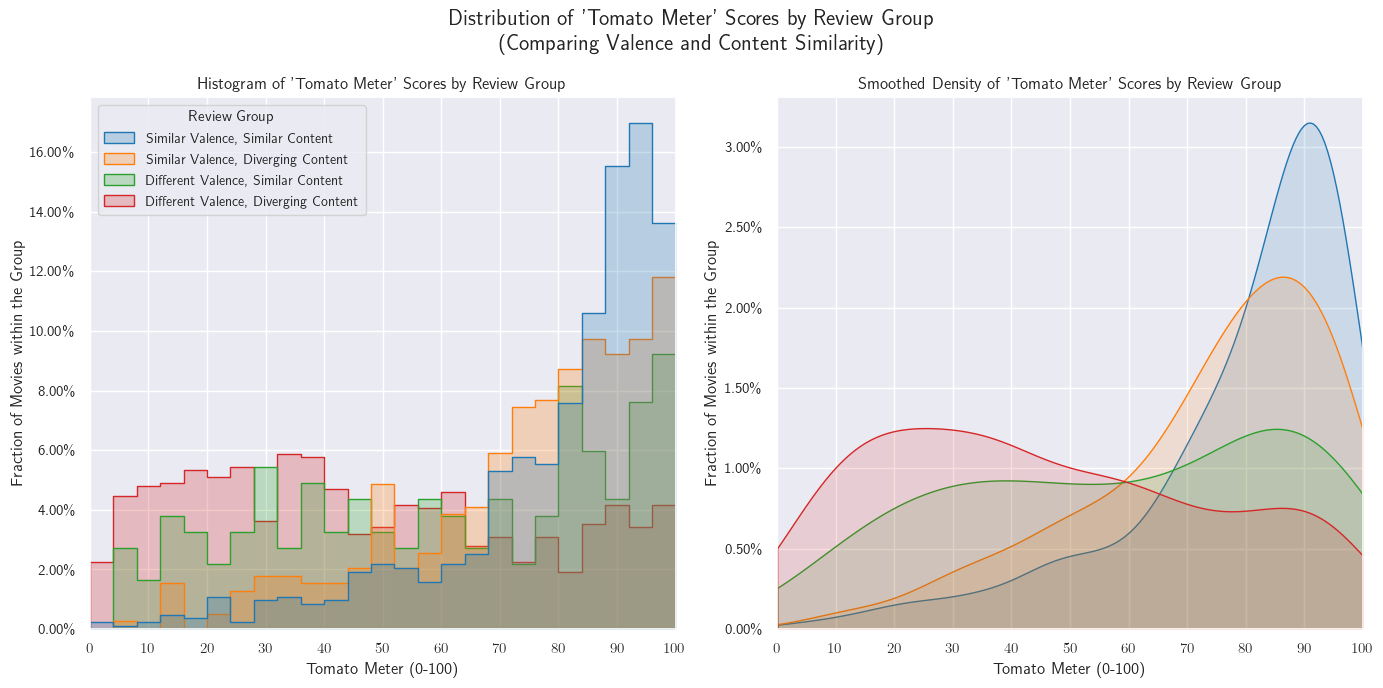

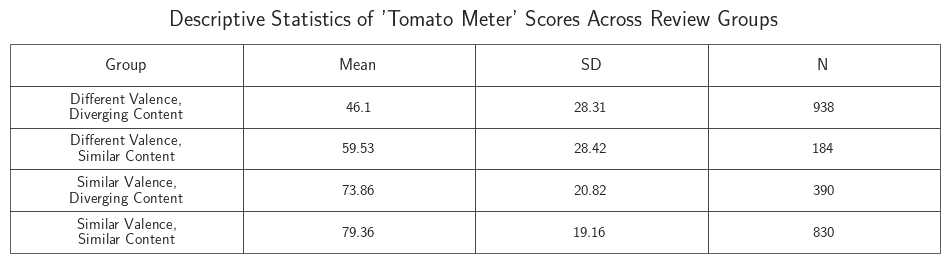

In [21]:
sns.set_theme(style="darkgrid")
fig, axes = plt.subplots(1,2, figsize=(14,7))
plt.suptitle("Distribution of 'Tomato Meter' Scores by Review Group\n(Comparing Valence and Content Similarity)", fontweight="bold", fontsize=16)

# Histplot
sns.histplot(data=combined, x="tomatoMeter", hue="group", bins=25, element="step", stat="probability", common_norm=False, palette=group_palette, ax=axes[0], legend=True)
axes[0].set_title("Histogram of 'Tomato Meter' Scores by Review Group", fontweight="bold")

# Format the automatically created legend
leg = axes[0].get_legend()
leg.set_title("Review Group")
plt.setp(leg.get_title(), fontsize=11, fontweight="bold")
plt.setp(leg.get_texts(), fontsize=10)

# KDE
for group in combined["group"].unique():
    sns.kdeplot(data=combined[combined["group"] == group], x="tomatoMeter", color=group_palette[group], bw_adjust=1.2, clip=(0, 100), ax=axes[1], fill=True, alpha=0.15)
axes[1].set_title("Smoothed Density of 'Tomato Meter' Scores by Review Group", fontweight="bold")

# Common styling
for ax in axes:
    ax.set_xlim(0, 100)
    ax.set_xticks(np.arange(0, 101, 10))
    ax.set_xlabel("Tomato Meter (0-100)")
    ax.set_ylabel("Fraction of Movies within the Group")
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{100*y:.2f}\%'))

plt.tight_layout()
plt.show()

sns.set_theme(style="white")
plt.figure(figsize=(8,3))
plt.axis("off")
plt.title("Descriptive Statistics of 'Tomato Meter' Scores Across Review Groups", fontweight="bold", fontsize=16)

# Summary Statistics
summary = combined.groupby("group").agg(Mean = ("tomatoMeter", "mean"),
                                        SD = ("tomatoMeter", "std"),
                                        N = ("tomatoMeter", "count")).reset_index().round({"Mean": 2, "SD": 2})
summary["group"] = summary["group"].replace({"Similar Valence, Similar Content": "Similar Valence,\nSimilar Content",
                                             "Similar Valence, Diverging Content": "Similar Valence,\nDiverging Content",
                                             "Different Valence, Similar Content": "Different Valence,\nSimilar Content",
                                             "Different Valence, Diverging Content": "Different Valence,\nDiverging Content"})
summary.rename(columns={"group": "Group"}, inplace=True)

# Create Table
table = plt.table(cellText = summary.values,
                      colLabels = summary.columns,
                      loc = "center",
                      cellLoc = "center")
table.scale(1.5, 2.5)

table.auto_set_font_size(False)
table.set_fontsize(11)
for key, cell in table.get_celld().items():
    cell.set_linewidth(0.5)
    if key[0] == 0:
        cell.set_fontsize(12)
        cell.set_text_props(weight="bold")


plt.show()

### Test for Normality

In [22]:
# Test  H₀: distribution is normal
#       H₁: distribution is not normal

stat1, p1 = stats.shapiro(sameVal_sameCon.dropna(subset=["tomatoMeter"])["tomatoMeter"])
stat2, p2 = stats.shapiro(sameVal_diffCon.dropna(subset=["tomatoMeter"])["tomatoMeter"])
stat3, p3 = stats.shapiro(diffVal_sameCon.dropna(subset=["tomatoMeter"])["tomatoMeter"])
stat4, p4 = stats.shapiro(diffVal_diffCon.dropna(subset=["tomatoMeter"])["tomatoMeter"])

print(f"Shapiro-Wilk test for normality:",
      f"\nSimilar Valence, Similar Content: {p1:.4f}",
      f"\nSimilar Valence, Diverging Content: {p2:.4f}",
      f"\nDifferent Valence, Similar Content: {p3:.4f}",
      f"\nDifferent Valence, Diverging Content: {p4:.4f}")

Shapiro-Wilk test for normality: 
Similar Valence, Similar Content: 0.0000 
Similar Valence, Diverging Content: 0.0000 
Different Valence, Similar Content: 0.0000 
Different Valence, Diverging Content: 0.0000


### Test for Log-Normality

/Users/renatoromagna/Desktop/UZH/Masterarbeit/Master's Thesis Code/.venv/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


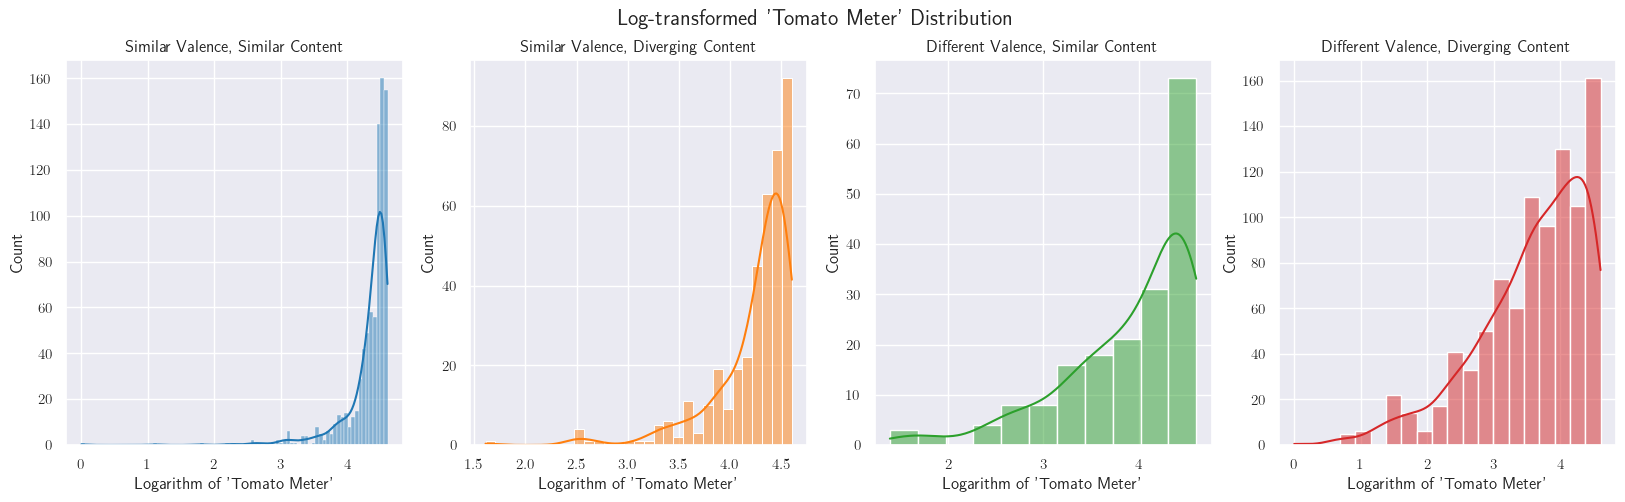

Shapiro-Wilk test for lognormality: 
Similar Valence, Similar Content: 0.0000 
Similar Valence, Diverging Content: 0.0000 
Different Valence, Similar Content: 0.0000 
Different Valence, Diverging Content: 1.0000


In [23]:
# Test  H₀: distribution is log-normal
#       H₁: distribution is not log-normal

sns.set_theme(style="darkgrid")
fig, axes = plt.subplots(1,4, figsize=(20,5))
plt.suptitle("Log-transformed 'Tomato Meter' Distribution", fontweight="bold", fontsize=16)

log_values1 = np.log(sameVal_sameCon.dropna(subset=["tomatoMeter"])["tomatoMeter"])
sns.histplot(log_values1, kde=True, ax=axes[0], color=group_palette["Similar Valence, Similar Content"])
axes[0].set_xlabel("Logarithm of 'Tomato Meter'")
axes[0].set_title("Similar Valence, Similar Content")

log_values2 = np.log(sameVal_diffCon.dropna(subset=["tomatoMeter"])["tomatoMeter"])
sns.histplot(log_values2, kde=True, ax=axes[1], color=group_palette["Similar Valence, Diverging Content"])
axes[1].set_xlabel("Logarithm of 'Tomato Meter'")
axes[1].set_title("Similar Valence, Diverging Content")

log_values3 = np.log(diffVal_sameCon.dropna(subset=["tomatoMeter"])["tomatoMeter"])
sns.histplot(log_values3, kde=True, ax=axes[2], color=group_palette["Different Valence, Similar Content"])
axes[2].set_xlabel("Logarithm of 'Tomato Meter'")
axes[2].set_title("Different Valence, Similar Content")

log_values4 = np.log(diffVal_diffCon.dropna(subset=["tomatoMeter"])["tomatoMeter"])
sns.histplot(log_values4, kde=True, ax=axes[3], color=group_palette["Different Valence, Diverging Content"])
axes[3].set_xlabel("Logarithm of 'Tomato Meter'")
axes[3].set_title("Different Valence, Diverging Content")

plt.show()

# Test for normality (lognormality implies this should be ~normal)
stat1, p1 = stats.shapiro(log_values1)
stat2, p2 = stats.shapiro(log_values2)
stat3, p3 = stats.shapiro(log_values3)
stat4, p4 = stats.shapiro(log_values4)

print(f"Shapiro-Wilk test for lognormality:",
      f"\nSimilar Valence, Similar Content: {p1:.4f}",
      f"\nSimilar Valence, Diverging Content: {p2:.4f}",
      f"\nDifferent Valence, Similar Content: {p3:.4f}",
      f"\nDifferent Valence, Diverging Content: {p4:.4f}")


### Kruskal-Wallis H-Test (Test if the Distributions differ from each other)

In [24]:
# Test  H₀: distributions are identical
#       H₁: at least one distribution differs

groups = [group["tomatoMeter"].dropna() for _, group in combined.groupby("group")]
H, p = stats.kruskal(*groups)
print(f"Kruskal–Wallis H = {H:.3f}, p = {p:.4f}")

Kruskal–Wallis H = 610.169, p = 0.0000


### Pairwise Mann-Whitney U-Tests

In [25]:
# Test  H₀: distributions are identical
#       H₁: distribution differ from each other

groups_dict = {name: group["tomatoMeter"].dropna() for name, group in combined.groupby("group")}

pairs = []
for (g1, g2) in combinations(groups_dict.keys(), 2):
    u, p = stats.mannwhitneyu(groups_dict[g1], groups_dict[g2], alternative='two-sided')
    pairs.append([g1, g2, u, p])

results = pd.DataFrame(pairs, columns=["Group 1", "Group 2", "U-statistic", "p-value"])
results["p (Bonferroni)"] = results["p-value"] * len(results)
results["Significant"] = results["p (Bonferroni)"] < 0.05
print(results)

                                Group 1                             Group 2   U-statistic  p-value  p (Bonferroni)  Significant
0  Different Valence, Diverging Content  Different Valence, Similar Content  63513.500000 0.000000        0.000000         True
1  Different Valence, Diverging Content  Similar Valence, Diverging Content  83296.500000 0.000000        0.000000         True
2  Different Valence, Diverging Content    Similar Valence, Similar Content 141113.500000 0.000000        0.000000         True
3    Different Valence, Similar Content  Similar Valence, Diverging Content  25921.000000 0.000000        0.000000         True
4    Different Valence, Similar Content    Similar Valence, Similar Content  45502.500000 0.000000        0.000000         True
5    Similar Valence, Diverging Content    Similar Valence, Similar Content 133311.500000 0.000001        0.000004         True


## Box Office Distributions

### Box Office Distributions

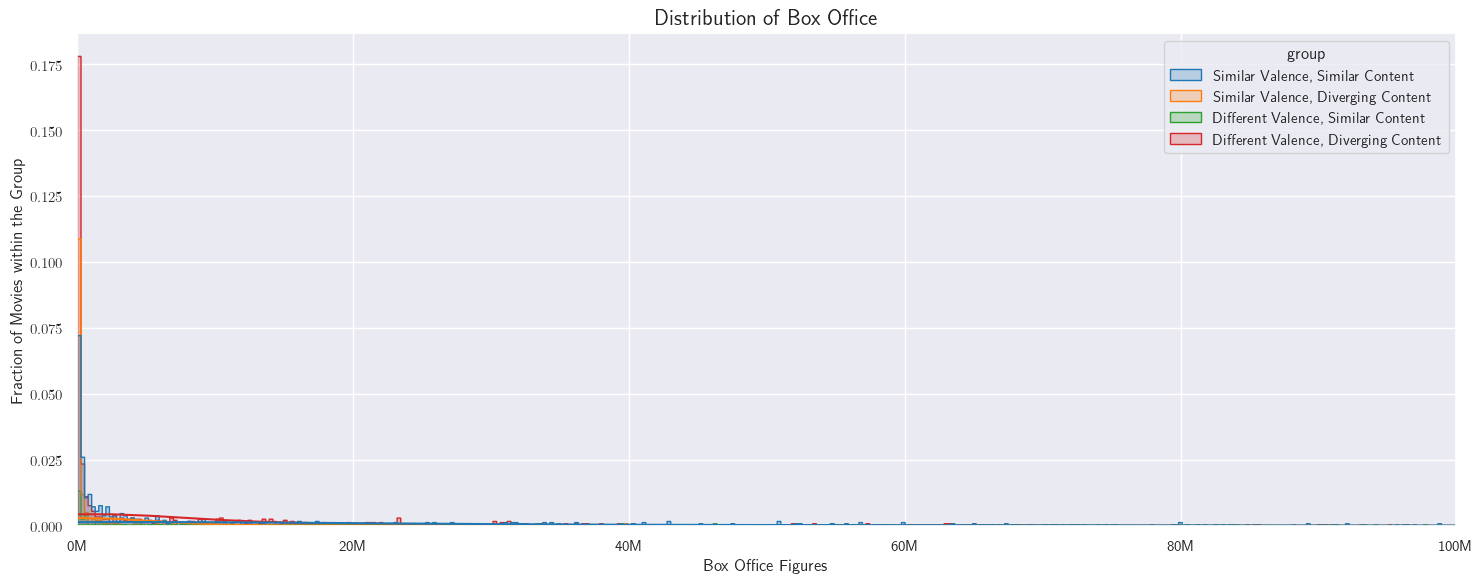

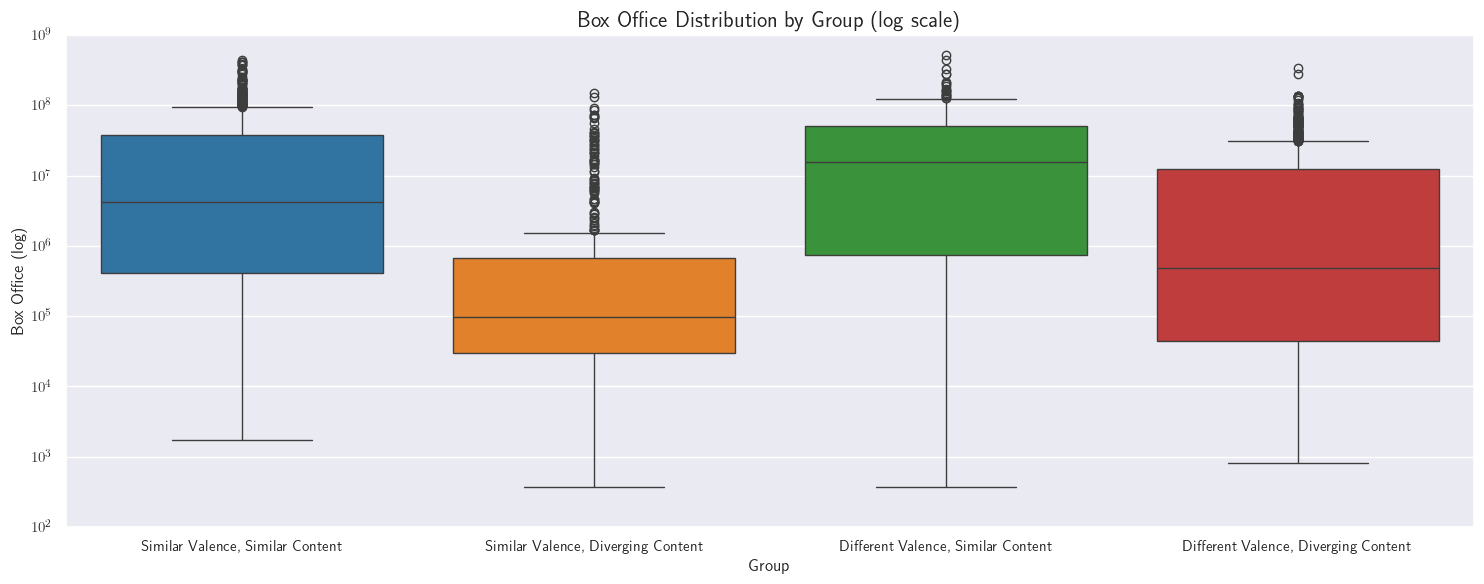

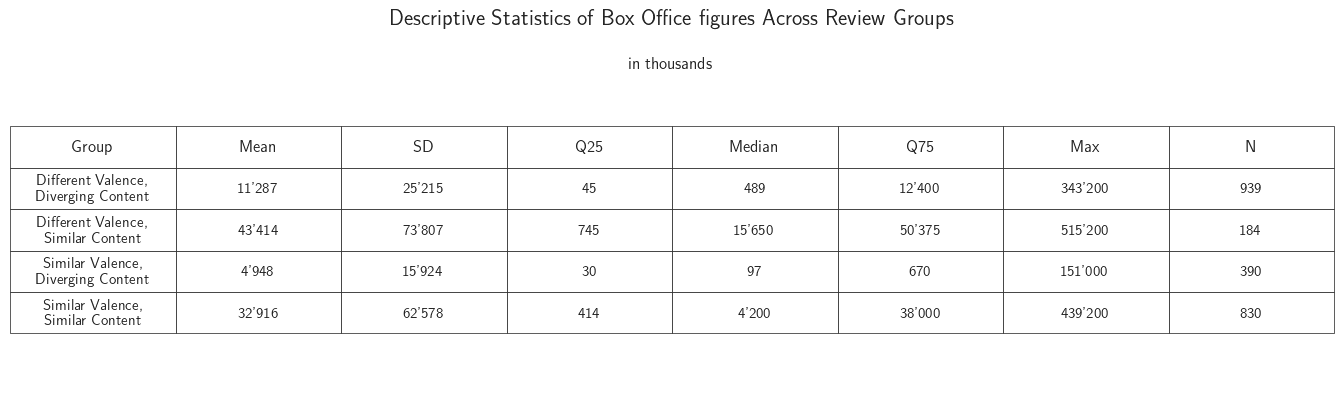

In [26]:
sns.set_theme(style="darkgrid")
# Histogram
fig, ax = plt.subplots(figsize=(15, 6))
sns.histplot(data=combined , x="boxOffice", bins = 2000, hue="group", stat="probability", element="step", palette=group_palette, kde=True, ax=ax)
ax.set_title("Distribution of Box Office", fontweight="bold", fontsize=16)
ax.set_ylabel("Fraction of Movies within the Group")
ax.set_xlabel("Box Office Figures")
ax.set_xlim((0,100000000))
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{int(x/1000000):,}M".replace(",", "'")))

plt.tight_layout()
plt.show()

# Boxplot
plt.figure(figsize=(15, 6))
sns.boxplot(data=combined, x="group", y="boxOffice", hue="group", palette=group_palette)
plt.yscale("log")
plt.title("Box Office Distribution by Group (log scale)", fontweight = "bold", fontsize=16)
plt.xlabel("Group")
plt.ylabel("Box Office (log)")
plt.ylim((100, 1000000000))

plt.tight_layout()
plt.show()

sns.set_theme(style="white")
plt.figure(figsize=(15,4))
plt.axis("off")
plt.suptitle("Descriptive Statistics of Box Office figures Across Review Groups", fontweight="bold", fontsize=16)
plt.title("in thousands", fontsize=12)

# Summary Statistics
summary = combined.groupby("group").agg(Mean = ("boxOffice", "mean"),
                                        SD = ("boxOffice", "std"),
                                        Q25 = ("boxOffice", lambda x: x.quantile(0.25)),
                                        Median = ("boxOffice", lambda x: x.quantile(0.5)),
                                        Q75 = ("boxOffice", lambda x: x.quantile(0.75)),
                                        Max = ("boxOffice", "max"),
                                        N = ("boxOffice", "count")).reset_index().round({"Mean": 2, "SD": 2, "Q25": 2, "Median": 2, "Q75": 2, "Max": 0})

summary["group"] = summary["group"].replace({"Similar Valence, Similar Content": "Similar Valence,\nSimilar Content",
                                             "Similar Valence, Diverging Content": "Similar Valence,\nDiverging Content",
                                             "Different Valence, Similar Content": "Different Valence,\nSimilar Content",
                                             "Different Valence, Diverging Content": "Different Valence,\nDiverging Content"})
summary.rename(columns={"group": "Group"}, inplace=True)

# Format Numbers
def format_k(x):
    """Convert numbers to 'x' K format with apostrophes, e.g., 10'000 K"""
    return f"{x/1000:,.0f}".replace(",", "'")

for col in ["Mean", "SD", "Q25", "Median", "Q75", "Max"]:
    summary[col] = summary[col].apply(format_k)

# Create Table
table = plt.table(cellText = summary.values,
                      colLabels = summary.columns,
                      loc = "center",
                      cellLoc = "center")
table.scale(1.5, 2.5)

table.auto_set_font_size(False)
table.set_fontsize(11)
for key, cell in table.get_celld().items():
    cell.set_linewidth(0.5)
    if key[0] == 0:
        cell.set_fontsize(12)
        cell.set_text_props(weight="bold")

plt.tight_layout()
plt.show()

### Test for Log-Normality

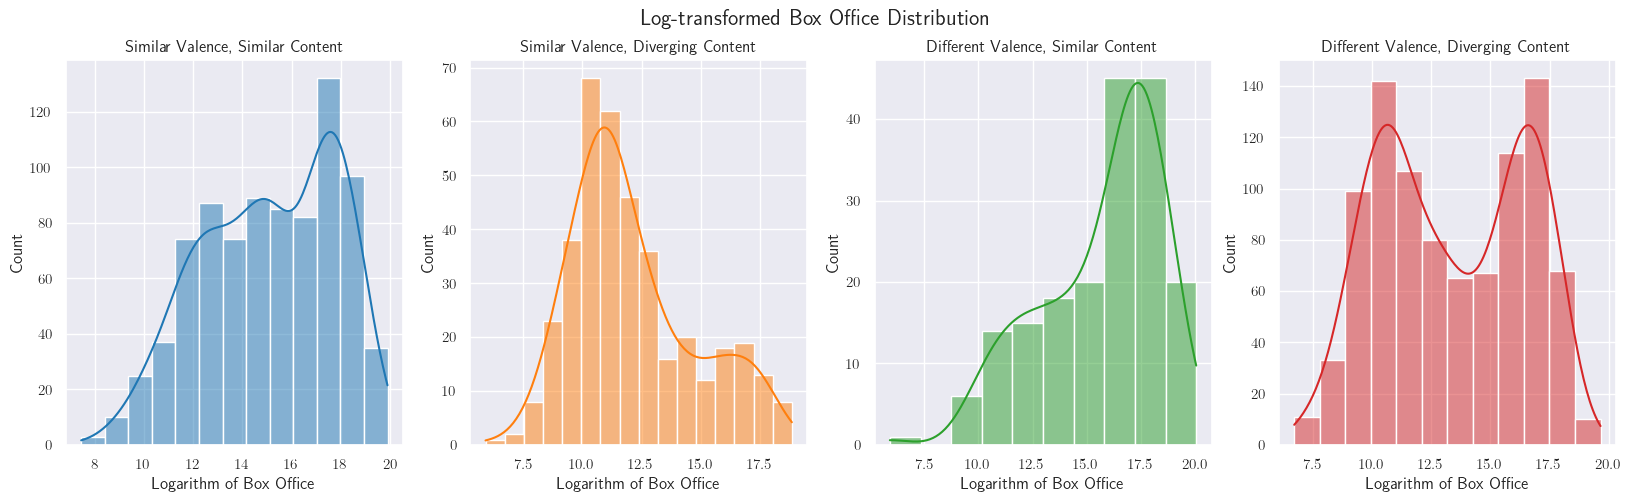

Shapiro-Wilk test for lognormality: 
Similar Valence, Similar Content: 0.0000 
Similar Valence, Diverging Content: 0.0000 
Different Valence, Similar Content: 0.0000 
Different Valence, Diverging Content: 0.0000


In [27]:
sns.set_theme(style="darkgrid")
fig, axes = plt.subplots(1,4, figsize=(20,5))
plt.suptitle("Log-transformed Box Office Distribution", fontweight="bold", fontsize=16)

log_values1 = np.log(sameVal_sameCon["boxOffice"])
sns.histplot(log_values1, kde=True, ax=axes[0], color=group_palette["Similar Valence, Similar Content"])
axes[0].set_xlabel("Logarithm of Box Office")
axes[0].set_title("Similar Valence, Similar Content")

log_values2 = np.log(sameVal_diffCon["boxOffice"])
sns.histplot(log_values2, kde=True, ax=axes[1], color=group_palette["Similar Valence, Diverging Content"])
axes[1].set_xlabel("Logarithm of Box Office")
axes[1].set_title("Similar Valence, Diverging Content")

log_values3 = np.log(diffVal_sameCon["boxOffice"])
sns.histplot(log_values3, kde=True, ax=axes[2], color=group_palette["Different Valence, Similar Content"])
axes[2].set_xlabel("Logarithm of Box Office")
axes[2].set_title("Different Valence, Similar Content")

log_values4 = np.log(diffVal_diffCon["boxOffice"])
sns.histplot(log_values4, kde=True, ax=axes[3], color=group_palette["Different Valence, Diverging Content"])
axes[3].set_xlabel("Logarithm of Box Office")
axes[3].set_title("Different Valence, Diverging Content")

plt.show()

# Test for normality (lognormality implies this should be ~normal)
stat1, p1 = stats.shapiro(log_values1)
stat2, p2 = stats.shapiro(log_values2)
stat3, p3 = stats.shapiro(log_values3)
stat4, p4 = stats.shapiro(log_values4)

print(f"Shapiro-Wilk test for lognormality:",
      f"\nSimilar Valence, Similar Content: {p1:.4f}",
      f"\nSimilar Valence, Diverging Content: {p2:.4f}",
      f"\nDifferent Valence, Similar Content: {p3:.4f}",
      f"\nDifferent Valence, Diverging Content: {p4:.4f}")


### Kruskal-Wallis H-Test (Test if the Distributions differ from each other)

In [28]:
# Test  H₀: distributions are identical
#       H₁: at least one distribution differs
groups = [g["boxOffice"].dropna() for _, g in combined.groupby("group")]
H, p = stats.kruskal(*groups)
print(f"Kruskal–Wallis H = {H:.3f}, p = {p:.4f}")

Kruskal–Wallis H = 351.011, p = 0.0000


### Pairwise Mann-Whitney U-Tests

In [29]:
# Test  H₀: distributions are identical
#       H₁: distribution differ from each other

groups_dict = {name: g["boxOffice"].dropna() for name, g in combined.groupby("group")}

pairs = []
for (g1, g2) in combinations(groups_dict.keys(), 2):
    u, p = stats.mannwhitneyu(groups_dict[g1], groups_dict[g2], alternative='two-sided')
    pairs.append([g1, g2, u, p])

results = pd.DataFrame(pairs, columns=["Group 1", "Group 2", "U-statistic", "p-value"])
results["p (Bonferroni)"] = results["p-value"] * len(results)
results["Significant"] = results["p (Bonferroni)"] < 0.05
print(results)

                                Group 1                             Group 2   U-statistic  p-value  p (Bonferroni)  Significant
0  Different Valence, Diverging Content  Different Valence, Similar Content  48915.000000 0.000000        0.000000         True
1  Different Valence, Diverging Content  Similar Valence, Diverging Content 225455.000000 0.000000        0.000000         True
2  Different Valence, Diverging Content    Similar Valence, Similar Content 263024.500000 0.000000        0.000000         True
3    Different Valence, Similar Content  Similar Valence, Diverging Content  59016.000000 0.000000        0.000000         True
4    Different Valence, Similar Content    Similar Valence, Similar Content  86325.000000 0.005563        0.033379         True
5    Similar Valence, Diverging Content    Similar Valence, Similar Content  68548.000000 0.000000        0.000000         True


# Thesis Plots

## Valence

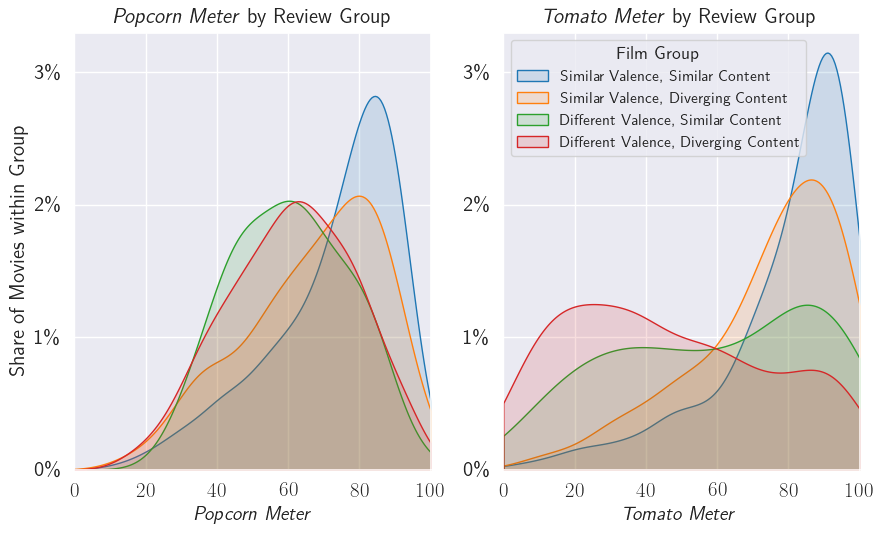

In [67]:
fig, axes = plt.subplots(1,2, figsize=(9,5.5), sharex=True, sharey=True)
sns.set_theme(style="darkgrid")

# KDE Popcorn Meter
for group in combined["group"].unique():
    sns.kdeplot(data=combined[combined["group"] == group], x="audienceScore", color=group_palette[group], bw_adjust=1.2, clip=(0, 100), ax=axes[0], fill=True, alpha=0.15, label=group)
axes[0].set_title("\emph{Popcorn Meter} by Review Group", fontweight="bold", fontsize=15)
axes[0].set_xlabel("\emph{Popcorn Meter}", fontsize=14)

# KDE Tomato Meter
for group in combined["group"].unique():
    sns.kdeplot(data=combined[combined["group"] == group], x="tomatoMeter", color=group_palette[group], bw_adjust=1.2, clip=(0, 100), ax=axes[1], fill=True, alpha=0.15, label=group)
axes[1].set_title("\emph{Tomato Meter} by Review Group", fontweight="bold", fontsize=15)
axes[1].set_xlabel("\emph{Tomato Meter}", fontsize=14)

# Common styling
for ax in axes:
    ax.set_xlim(0, 100)
    ax.set_ylim(0, 0.033)
    ax.set_xticks(np.arange(0, 101, 20))
    ax.set_yticks((0, 0.01, 0.02, 0.03))
    ax.set_ylabel("Share of Movies within Group", fontsize=15)
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{100*y:.0f}\%'))
    ax.tick_params(axis="x", labelsize=15)
    ax.tick_params(axis="y", labelsize=15, labelleft=True)

# Create & format the legend
leg = axes[1].legend(title="Film Group")
plt.setp(leg.get_title(), fontsize=13, fontweight="bold")
plt.setp(leg.get_texts(), fontsize=11.5)

plt.tight_layout()
plt.show()

## Box Office

/var/folders/s4/l2x3kbm513b5fgz675t9lszh0000gn/T/ipykernel_2700/864367474.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels)


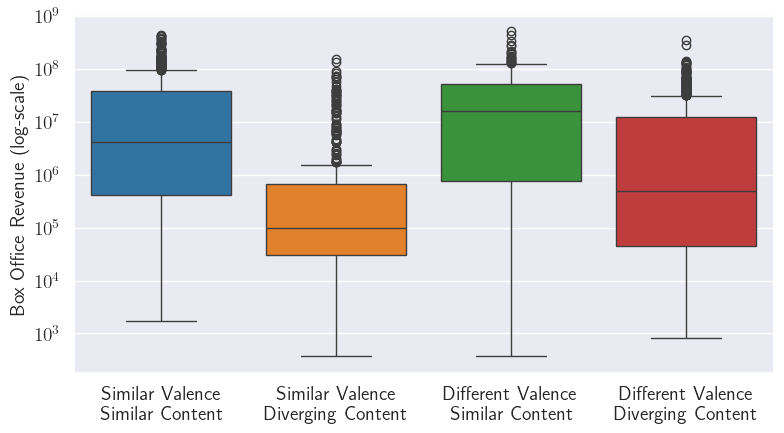

In [68]:
fig, ax = plt.subplots(1,1, figsize=(8,4.5))


# Boxplot
sns.boxplot(data=combined, x="group", y="boxOffice", hue="group", palette=group_palette, ax=ax)
ax.set_yscale("log")
ax.set_xlabel(None)
ax.set_ylabel("Box Office Revenue (log-scale)", fontsize=14)

labels = [label.get_text().replace(",", "\n") for label in ax.get_xticklabels()]
ax.set_xticklabels(labels)
ax.tick_params("x", labelsize=14, 
               #labelrotation=30
               )
ax.tick_params("y", labelsize=14)

plt.tight_layout()
plt.show()